In [15]:
# ============================================================
# Behavior Extraction Script
# From raw .mat and .csv files to clean 'behavior.csv'
# ============================================================

# === 1. Import libraries ===
import scipy.io
import pandas as pd
import numpy as np
import re
from collections import defaultdict

# === 2. Load raw files ===
sessions_data = scipy.io.loadmat('sessions.mat', simplify_cells=True)
beh_data = scipy.io.loadmat('behavior.mat', simplify_cells=True)
celebA_new = scipy.io.loadmat('CelebA_Image_Code_new.mat', simplify_cells=True)
celebA_old = scipy.io.loadmat('CelebA_Image_Code.mat', simplify_cells=True)
adjustment_data = scipy.io.loadmat('CelebA_Image_Code.mat', simplify_cells=True)  # same as celebA_old
adjust_ind = adjustment_data.get("AdjustInd", None)
gender_df = pd.read_csv('FaceImageIndex.csv')

# === 3. Initialize storage lists ===
session_ids, subject_ids, subject_nums = [], [], []
start_times, image_onsets, image_offsets = [], [], []
iti_starts, iti_durations, trial_ends = [], [], []
stimulus_indices, reaction_times, responses = [], [], []
trial_labels, is_one_back_flags, identities, recognitions = [], [], [], []
genders = []

# === 4. Set up mappings ===
identity_new = celebA_new['im_code']
identity_old = celebA_old['im_code']

face_index_to_identity_new = {i + 1: identity_new[i] for i in range(len(identity_new))}
face_index_to_identity_old = {i + 1: identity_old[i] for i in range(len(identity_old))}

first_10_sessions = {
    'p6WV_CelebA_Sess1', 'p6WV_CelebA_Sess2',
    'p7WV_CelebA_Sess1', 'p7WV_CelebA_Sess2', 'p7WV_CelebA_Sess3', 'p7WV_CelebA_Sess4',
    'p9WV_CelebA_Sess1', 'p9WV_CelebA_Sess2', 'p9WV_CelebA_Sess3', 'p9WV_CelebA_Sess4'
}

subject_mapping = {
    'p6WV': 1, 'p7WV': 2, 'p9WV': 3, 'p10WV': 4, 'p11WV': 5, 'p13WV': 6,
    'p14WV': 7, 'p15WV': 8, 'p16WV': 9, 'p18WV': 10, 'p19WV': 11, 'p20WV': 12
}

if 'StimulusIndex' in gender_df.columns and 'FaceIndex' in gender_df.columns:
    stimulus_index_to_face_index = dict(zip(gender_df['StimulusIndex'], gender_df['FaceIndex']))
elif 'FaceIndex' in gender_df.columns:
    stimulus_index_to_face_index = {i + 1: face_index for i, face_index in enumerate(gender_df['FaceIndex'])}
else:
    raise ValueError("FaceImageIndex.csv missing expected columns.")

recognition_mapping = {
    'p6WV': {1, 3, 4, 5, 6, 8, 9, 10, 11, 13, 15, 17, 18, 19, 21, 23, 24, 27, 28, 29, 30, 31, 32, 33, 37, 39, 41, 43, 44, 45, 46, 50},
    'p7WV': {2, 6, 10, 14, 15, 18, 24, 29, 31, 44},
    'p9WV': set(),
    'p10WV': {1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 15, 19, 20, 21, 22, 23, 26, 27, 32, 33, 34, 35, 37, 39, 40, 42, 43, 44, 45, 46, 47, 49},
    'p11WV': {8, 11, 13, 14, 17, 18, 22, 25, 29, 30, 31, 32, 35, 36, 37, 38, 40, 41, 42, 44, 45, 47, 50},
    'p13WV': set(),
    'p14WV': {1, 2, 5, 6, 9, 13, 14, 17, 18, 19, 20, 21, 22, 24, 26, 27, 28, 29, 30, 31, 32, 36, 40, 41, 43, 44, 46, 47, 48, 50},
    'p15WV': set(),
    'p16WV': {2, 3, 5, 6, 7, 8, 10, 13, 14, 17, 18, 19, 20, 24, 28, 29, 30, 31, 32, 35, 36, 37, 41, 44, 45, 47},
    'p18WV': {5, 8, 10, 11, 13, 18, 29, 30, 32, 33, 37, 48},
    'p19WV': {14, 30, 31, 33},
    'p20WV': {5, 6, 8, 13, 16, 19, 23, 24, 28, 29, 30, 32, 44}
}

# === 5. Helper functions ===
def get_identity(subject, session, stimulus_index):
    full_session_id = f"{subject}_CelebA_{session}"
    if stimulus_index is None or pd.isna(stimulus_index):
        return None
    face_index = stimulus_index_to_face_index.get(int(stimulus_index), None)
    if face_index is None:
        return None
    if full_session_id in first_10_sessions and adjust_ind is not None:
        if face_index - 1 >= len(adjust_ind):
            return None
        adjusted_stimulus = adjust_ind[face_index - 1]
        if adjusted_stimulus == 0:
            return None
        return face_index_to_identity_old.get(adjusted_stimulus, None)
    return face_index_to_identity_new.get(face_index, None)

def determine_recognition(subject, identity):
    if pd.isna(identity) or subject not in recognition_mapping:
        return 0
    return 1 if int(identity) in recognition_mapping[subject] else 0

def clean_session_name(session):
    match = re.search(r"(S|Sess)(\d+)", session, re.IGNORECASE)
    if match:
        return f"s{match.group(2)}"
    else:
        return "unknown"

# === 6. Parse behavior sessions ===

# (1) Group trials by subject-session
grouped_sessions = defaultdict(list)
for session_idx in range(len(beh_data['beh'])):
    full_id = sessions_data['sessions'][session_idx]['ID']

    # --- Skip bad sessions early ---
    if full_id in ['p10WV_CelebA_Sesse', 'p11WV_CelebA_Sesse']:
        print(f"Skipping bad session: {full_id}")
        continue

    subject = full_id.split('_')[0]  # Example: p6WV
    session = full_id.split('_')[-1]  # Example: Sess1
    grouped_sessions[f"{subject}_{session}"].append(session_idx)

# (2) Now go through grouped sessions
for key, session_indices in grouped_sessions.items():
    subject_id, session_id = key.split('_')
    subject_num = subject_mapping.get(subject_id, np.nan)

    # --- Special case for p9WV Sess2 where multiple sessions were merged ---
    is_p9wv_sess2 = (subject_id == "P9WV" and session_id == "Sess2")

    if is_p9wv_sess2:
        # Merge multiple files into one big session
        merged_trial_data, merged_vresp, merged_rt = [], [], []
        merged_code = []
        total_trials = 0

        for idx in session_indices:
            beh = beh_data['beh'][idx]
            merged_trial_data.extend(beh['iT'])
            merged_vresp.extend(beh['vResp'])
            merged_rt.extend(beh['RT'])
            merged_code.extend(beh['code'])
            total_trials += len(beh['iT'])

        trial_data = merged_trial_data
        vresp_session = merged_vresp
        rt_session = merged_rt
        stimuli_for_session = merged_code

    else:
        # Normal (single file) session
        idx = session_indices[0]
        beh = beh_data['beh'][idx]
        trial_data = beh['iT']
        vresp_session = beh['vResp']
        rt_session = beh['RT']
        stimuli_for_session = beh['code']

    # (3) Process trial by trial
    seen_stimulus_last = None  # Track for one-back logic

    for trial_idx, trial in enumerate(trial_data):
        # Extract event timestamps
        start_time = trial.get('TRIAL_START', None)
        image_onset = trial.get('IMAGE_ONSET', None)
        image_offset = trial.get('IMAGE_OFFSET', None)
        iti_start = trial.get('ITI_START', None)
        iti_duration = trial.get('ITI', None)
        trial_end = trial.get('TRIAL_END', None)

        # Get behavioral responses
        stimulus_idx = stimuli_for_session[trial_idx] if trial_idx < len(stimuli_for_session) else None
        vresp = vresp_session[trial_idx] if trial_idx < len(vresp_session) else None
        rt = rt_session[trial_idx] if trial_idx < len(rt_session) else 0
        rt = 0 if pd.isna(rt) else rt

        # --- One-back check (was this the same image as last trial?) ---
        is_one_back = (stimulus_idx == seen_stimulus_last)

        # --- Label trial Correct/Incorrect based on vResp and one-back ---
        label = "Correct" if ((is_one_back and vresp == 1) or (not is_one_back and vresp == 0)) else "Incorrect"
        seen_stimulus_last = stimulus_idx  # Update for next trial

        # --- Map image to Identity and Recognition ---
        identity = get_identity(subject_id, session_id, stimulus_idx)
        recognition = determine_recognition(subject_id, identity)

        # --- Get gender if known ---
        gender = None
        if identity is not None:
            try:
                gender = gender_df.loc[gender_df['FaceIndex'] == float(identity), 'Gender'].values[0]
            except IndexError:
                gender = None

        # --- Store everything ---
        session_ids.append(session_id)
        subject_ids.append(subject_id)
        subject_nums.append(subject_num)
        start_times.append(start_time)
        image_onsets.append(image_onset)
        image_offsets.append(image_offset)
        iti_starts.append(iti_start)
        iti_durations.append(iti_duration)
        trial_ends.append(trial_end)
        stimulus_indices.append(stimulus_idx)
        reaction_times.append(rt)
        responses.append(vresp)
        is_one_back_flags.append(is_one_back)
        trial_labels.append(label)
        identities.append(identity)
        recognitions.append(recognition)
        genders.append(gender)

# === 7. Create the raw dataframe ===
behavior_df = pd.DataFrame({
    'subject': subject_ids,
    'subject_num': subject_nums,
    'session': session_ids,
    'stimulus_index': stimulus_indices,
    'start_time': start_times,
    'image_onset': image_onsets,
    'image_offset': image_offsets,
    'iti_start': iti_starts,
    'iti_duration': iti_durations,
    'trial_end': trial_ends,
    'reaction_time': reaction_times,
    'response': responses,
    'is_one_back': is_one_back_flags,
    'label': trial_labels,
    'identity': identities,
    'recognition': recognitions,
    'gender': genders,
})

behavior_df["trial_index"] = behavior_df.groupby(["subject", "session"]).cumcount()

# === 10. Filter out bad identities (not 1–50) ===
bad_trials = behavior_df[(behavior_df['identity'] < 1) | (behavior_df['identity'] > 50)]
print(f"Number of bad trials: {len(bad_trials)}")

behavior_df = behavior_df[(behavior_df['identity'] >= 1) & (behavior_df['identity'] <= 50)]

# === 11. View behavior file ===
behavior_df

Number of bad trials: 11


,subject,subject_num,session,stimulus_index,start_time,image_onset,image_offset,iti_start,iti_duration,trial_end,reaction_time,response,is_one_back,label,identity,recognition,gender,trial_index
0,p6WV,1,Sess1,452,4.649819e+03,4.649845e+03,4.650851e+03,4.650876e+03,0.629914,4651.572551,0.0,0,False,Correct,35.0,0,F,0
1,p6WV,1,Sess1,123,4.651573e+03,4.651592e+03,4.652595e+03,4.652625e+03,0.697128,4653.358776,0.0,0,False,Correct,10.0,1,F,1
2,p6WV,1,Sess1,448,4.653359e+03,4.653375e+03,4.654378e+03,4.654408e+03,0.566485,4655.010962,0.0,0,False,Correct,22.0,0,M,2
3,p6WV,1,Sess1,99,4.655012e+03,4.655025e+03,4.656027e+03,4.656057e+03,0.649660,4656.744089,0.0,0,False,Correct,47.0,0,F,3
4,p6WV,1,Sess1,174,4.656745e+03,4.656758e+03,4.657761e+03,4.657790e+03,0.639448,4658.46694,0.0,0,False,Correct,38.0,0,M,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20138,p20WV,12,S2,438,1.471987e+06,1.471987e+06,1.471988e+06,1.471988e+06,0.706013,1471988.45226,0.0,0,False,Correct,23.0,1,M,550
20139,p20WV,12,S2,39,1.471988e+06,1.471988e+06,1.471989e+06,1.471989e+06,0.540635,1471990.102879,0.0,0,False,Correct,18.0,0,F,551
20140,p20WV,12,S2,328,1.471990e+06,1.471990e+06,1.471991e+06,1.471991e+06,0.700170,1471991.910955,0.0,0,False,Correct,38.0,0,M,552
20141,p20WV,12,S2,53,1.471992e+06,1.471992e+06,1.471993e+06,1.471993e+06,0.585684,1471993.612353,0.0,0,False,Correct,28.0,1,F,553


In [16]:
#Save the cleaned DataFrame to a CSV file
behavior_df.to_csv('behavior.csv', index=False)
print("Behavior extraction complete. Data saved to 'behavior.csv'.")

Behavior extraction complete. Data saved to 'behavior.csv'.


In [17]:
# Count total number of correct and incorrect trials
correct_trials = behavior_df[behavior_df['label'] == 'Correct']
incorrect_trials = behavior_df[behavior_df['label'] == 'Incorrect']

print(f"Number of correct trials: {len(correct_trials)}")
print(f"Number of incorrect trials: {len(incorrect_trials)}")

Number of correct trials: 19629
Number of incorrect trials: 477


In [18]:
# Step 1 — Look at the sessions that exist in your behavior dataframe
print("Unique sessions in behavior_df:")
print(sorted(behavior_df['session'].unique()))


Unique sessions in behavior_df:
['S1', 'S2', 'S3', 'S4', 'S5', 'Sess1', 'Sess2', 'Sess3', 'Sess4', 'Sess5']


In [19]:
# Step 2 — Confirm automatically if bad sessions are absent
bad_sessions = ['Sess12', 'Sess18']

# Check if any bad session is still in the behavior
bad_sessions_present = [s for s in bad_sessions if s in behavior_df['session'].unique()]

if len(bad_sessions_present) == 0:
    print("SUCCESS: No bad sessions found in behavior_df!")
else:
    print(f"WARNING: Bad sessions still present: {bad_sessions_present}")


SUCCESS: No bad sessions found in behavior_df!


In [20]:
# How many trials now in behavior_df?
print(f"Total number of trials in behavior_df: {len(behavior_df)}")

# Just to be extra sure: Show all session counts
print(behavior_df['session'].value_counts().sort_index())


Total number of trials in behavior_df: 20106
session
S1       4366
S2       4420
S3       1655
S4       2210
S5        555
Sess1    2189
Sess2    1797
Sess3    1271
Sess4    1093
Sess5     550
Name: count, dtype: int64


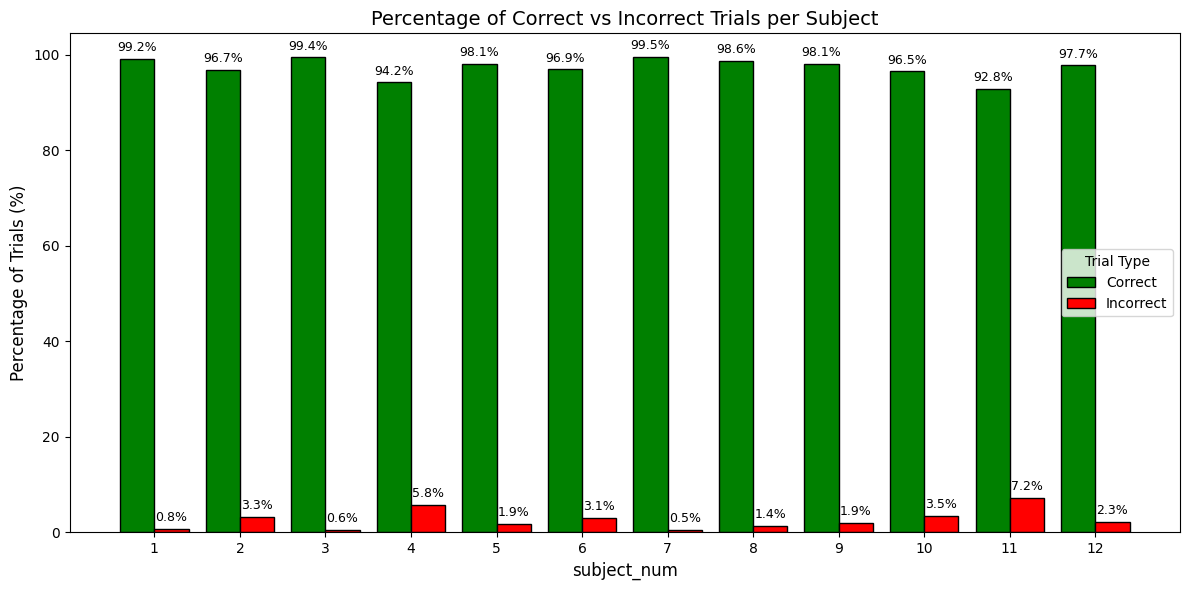

In [21]:
# ============================================================
# Plotting Correct vs Incorrect Trials per Subject (using Subject ID)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Load cleaned behavior.csv ===
file_path = "behavior.csv"
behavior_df = pd.read_csv(file_path)

# === Group by Subject ID and Label ===
trial_counts = behavior_df.groupby(["subject_num", "label"]).size().unstack(fill_value=0)

# === Sort Subject IDs ===
trial_counts = trial_counts.sort_index()

# === Convert trial counts to percentages ===
trial_counts_percentage = trial_counts.div(trial_counts.sum(axis=1), axis=0) * 100

# === Plotting ===
bar_width = 0.4
subject_indices = np.arange(len(trial_counts_percentage))

plt.figure(figsize=(12, 6))

# Bars for Correct and Incorrect
bars_correct = plt.bar(subject_indices - bar_width/2, 
                       trial_counts_percentage["Correct"], 
                       width=bar_width, label="Correct", color="green", edgecolor="black")

bars_incorrect = plt.bar(subject_indices + bar_width/2, 
                         trial_counts_percentage["Incorrect"], 
                         width=bar_width, label="Incorrect", color="red", edgecolor="black")

# Add labels on top of bars
for rect in bars_correct + bars_incorrect:
    height = rect.get_height()
    if height > 0:
        plt.text(rect.get_x() + rect.get_width()/2, height + 1, 
                 f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

# Customize the plot
plt.xlabel("subject_num", fontsize=12)
plt.ylabel("Percentage of Trials (%)", fontsize=12)
plt.title("Percentage of Correct vs Incorrect Trials per Subject", fontsize=14)
plt.xticks(subject_indices, trial_counts.index.astype(int))  # Subject IDs from 1–12
plt.legend(title="Trial Type")
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

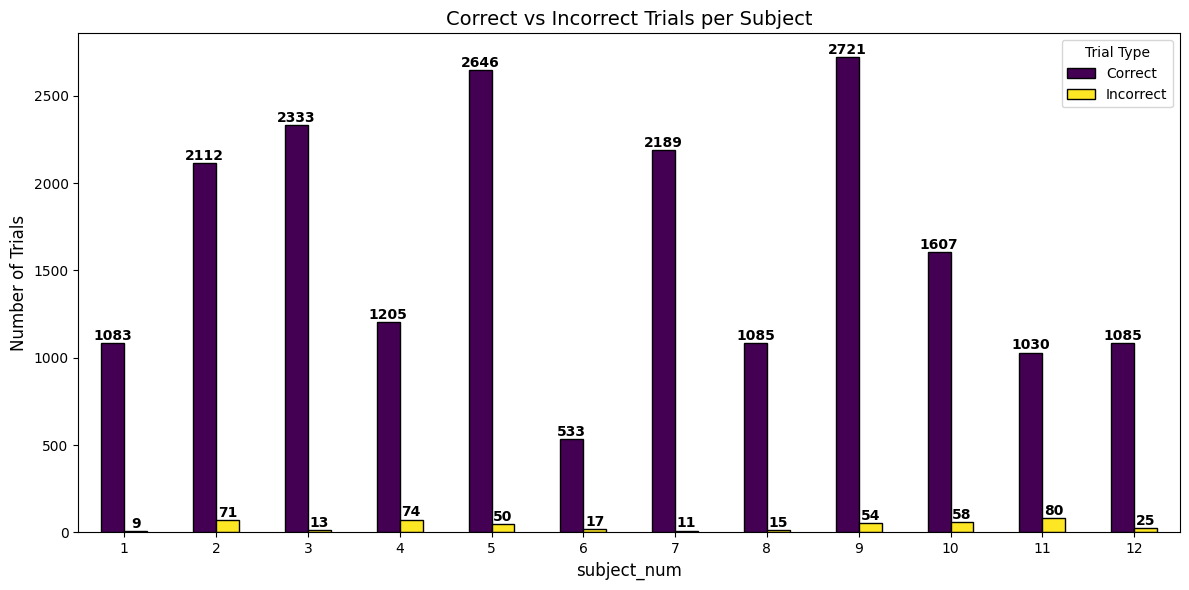

In [22]:
# ============================================================
# Plotting Number of Correct and Incorrect Trials (using Subject ID)
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Load behavior data ===
behavior_df = pd.read_csv("behavior.csv")

# === Group by Subject ID and Label ===
trial_counts = behavior_df.groupby(["subject_num", "label"]).size().unstack(fill_value=0)

# === Sort subjects by ID ===
trial_counts = trial_counts.sort_index()

# === Plot bar chart ===
plt.figure(figsize=(12, 6))
ax = trial_counts.plot(kind="bar", stacked=False, colormap="viridis", edgecolor="black", figsize=(12, 6))

# === Add value labels on bars ===
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f"{int(height)}", 
                    (p.get_x() + p.get_width() / 2, height + 1),  # small padding
                    ha="center", va="bottom", fontsize=10, fontweight="bold")

# === Customize plot ===
plt.xlabel("subject_num", fontsize=12)
plt.ylabel("Number of Trials", fontsize=12)
plt.title("Correct vs Incorrect Trials per Subject", fontsize=14)
plt.xticks(rotation=0)
plt.legend(title="Trial Type")
plt.tight_layout()
plt.show()

In [23]:
# ============================================================
# Calculate Average Reaction Time per Subject (using Subject ID)
# ============================================================

import pandas as pd

# === Load behavior data ===
behavior_df = pd.read_csv("behavior.csv")

# === Calculate average reaction time (ignores NaNs) ===
average_reaction_time = behavior_df.groupby("subject_num")["reaction_time"].mean()

# === Convert to milliseconds ===
average_reaction_time_ms = average_reaction_time * 1000  # from seconds to milliseconds

# === Sort by Subject ID ===
average_reaction_time_ms = average_reaction_time_ms.sort_index()

# === Display results ===
print("Average Reaction Time (ms) per Subject:")
average_reaction_time_ms.round(2)

Average Reaction Time (ms) per Subject:


subject_num
1     36.92
2     10.47
3     30.45
4      4.80
5     25.91
6      4.85
7     14.41
8     12.79
9     26.16
10     5.24
11     3.61
12     1.26
Name: reaction_time, dtype: float64

In [24]:
# ============================================================
# Calculate Overall Average Reaction Time across Subjects
# ============================================================

# === Overall average reaction time in milliseconds ===
overall_avg_reaction_time = average_reaction_time_ms.mean()

# === Display result ===
print(f"\nOverall Average Reaction Time across all subjects: {overall_avg_reaction_time:.2f} ms")



Overall Average Reaction Time across all subjects: 14.74 ms


In [25]:
# ============================================================
# Average Reaction Time for Correct Trials Only
# ============================================================

# === Filter for correct trials where a Reaction Time exists ===
correct_trials_with_rt = behavior_df[(behavior_df['label'] == 'Correct') & (behavior_df['reaction_time'].notna())]

# === Calculate average Reaction Time for correct trials (in ms) ===
avg_rt_correct_ms = correct_trials_with_rt['reaction_time'].mean() * 1000

# === Print result ===
print(f"Average Reaction Time for correct trials: {avg_rt_correct_ms:.2f} ms")


Average Reaction Time for correct trials: 17.62 ms


/tmp/ipykernel_2955884/732445891.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


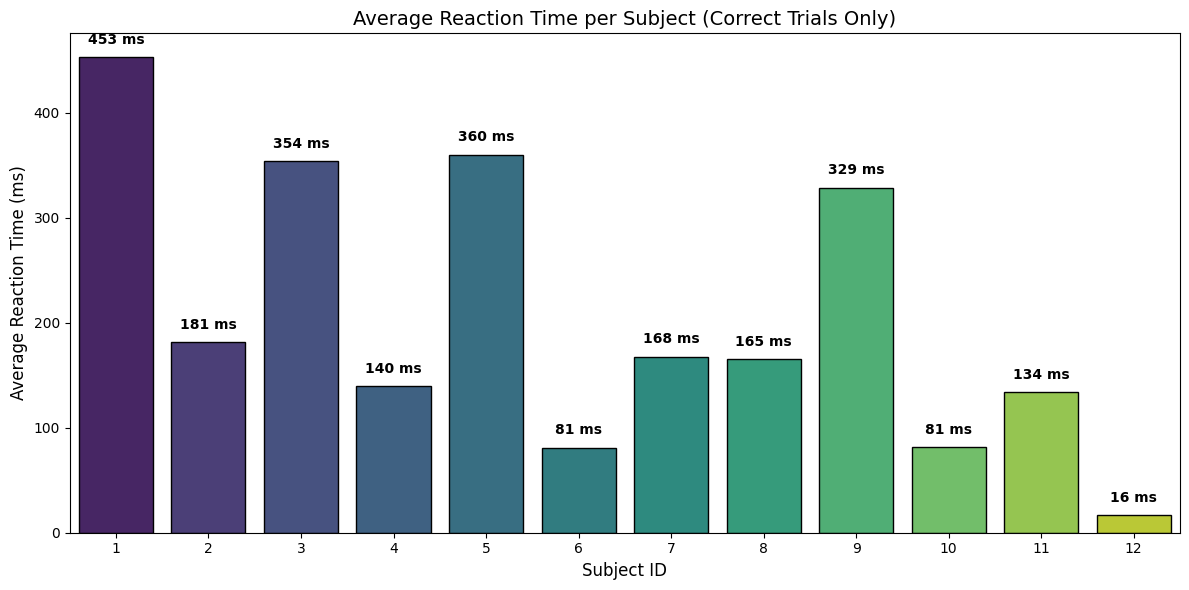

In [26]:
# ============================================================
# Plotting Average Reaction Time per Subject (Correct Trials Only)
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Load dataset ===
file_path = "behavior.csv"
behavior_df = pd.read_csv(file_path)

# === Filter for correct trials with non-zero Reaction Time ===
correct_trials = behavior_df[(behavior_df["label"] == "Correct") & (behavior_df["reaction_time"] > 0)]

# === Compute average Reaction Time per Subject ID ===
average_reaction_time = correct_trials.groupby("subject_num")["reaction_time"].mean()
average_reaction_time_ms = average_reaction_time * 1000  # Convert seconds to ms

# === Sort by Subject ID ===
average_reaction_time_ms = average_reaction_time_ms.sort_index()

# === Plot ===
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x=average_reaction_time_ms.index.astype(int),  # Convert index to int for cleaner X-axis
    y=average_reaction_time_ms.values,
    palette="viridis", edgecolor="black"
)

# === Add labels on bars ===
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f"{height:.0f} ms",
                (p.get_x() + p.get_width() / 2, height + 10),
                ha="center", va="bottom", fontsize=10, fontweight="bold")

# === Customize plot ===
plt.xlabel("Subject ID", fontsize=12)
plt.ylabel("Average Reaction Time (ms)", fontsize=12)
plt.title("Average Reaction Time per Subject (Correct Trials Only)", fontsize=14)
plt.xticks(rotation=0)

# === Final layout ===
plt.tight_layout()
plt.show()

/tmp/ipykernel_2955884/1770990967.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correct_trials["Reaction Time (ms)"] = correct_trials["reaction_time"] * 1000
/tmp/ipykernel_2955884/1770990967.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_2955884/1770990967.py:35: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


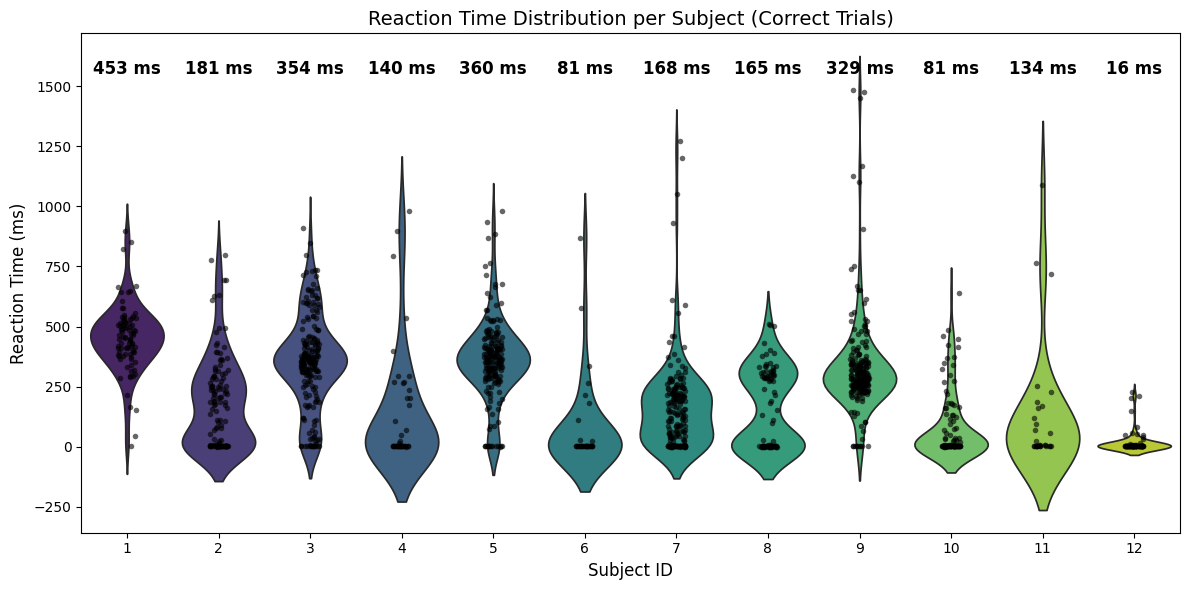

In [27]:
# ============================================================
# Reaction Time Distribution per Subject (Violin + Strip Plot)
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Load Dataset ===
behavior_df = pd.read_csv("behavior.csv")

# === Filter only correct trials with Reaction Time > 0 ===
correct_trials = behavior_df[
    (behavior_df["label"] == "Correct") &
    (behavior_df["reaction_time"].notna()) &
    (behavior_df["reaction_time"] > 0)
]

# === Convert Reaction Times to milliseconds ===
correct_trials["Reaction Time (ms)"] = correct_trials["reaction_time"] * 1000

# === Sort Subject IDs ===
sorted_subjects = sorted(correct_trials["subject_num"].unique())

# === Compute mean RT per subject ===
mean_reaction_times = correct_trials.groupby("subject_num")["Reaction Time (ms)"].mean()

# === Set fixed annotation height (slightly above max RT) ===
annotation_height = correct_trials["Reaction Time (ms)"].max() + 50

# === Plot setup ===
plt.figure(figsize=(12, 6))

# --- Violin plot for RT distribution ---
sns.violinplot(
    x="subject_num", y="Reaction Time (ms)", data=correct_trials,
    palette="viridis", inner=None, scale="width", order=sorted_subjects
)

# --- Scatter plot for individual RTs ---
sns.stripplot(
    x="subject_num", y="Reaction Time (ms)", data=correct_trials,
    color="black", size=4, jitter=True, alpha=0.6, order=sorted_subjects
)

# --- Annotate mean RT per subject ---
for i, subject in enumerate(sorted_subjects):
    avg_rt = mean_reaction_times[subject]
    plt.text(i, annotation_height, f"{avg_rt:.0f} ms",
             ha="center", va="bottom", fontsize=12, fontweight="bold", color="black")

# === Customize plot ===
plt.xlabel("Subject ID", fontsize=12)
plt.ylabel("Reaction Time (ms)", fontsize=12)
plt.title("Reaction Time Distribution per Subject (Correct Trials)", fontsize=14)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

/tmp/ipykernel_2955884/1514629541.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=behavior_df, x='gender', palette='Set2')


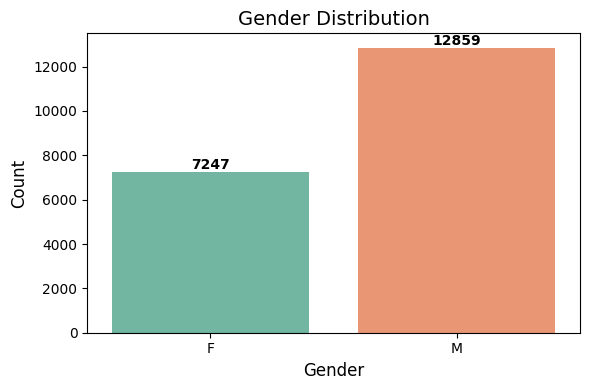

In [28]:
# ============================================================
# Plotting Gender Distribution
# ============================================================

import seaborn as sns
import matplotlib.pyplot as plt

# === Plot ===
plt.figure(figsize=(6, 4))
ax = sns.countplot(data=behavior_df, x='gender', palette='Set2')

# === Add value labels on top ===
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(str(count),
                (p.get_x() + p.get_width() / 2., p.get_height() + 1),
                ha='center', va='bottom', fontweight='bold')

# === Customize plot ===
plt.title('Gender Distribution', fontsize=14)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.tight_layout()
plt.show()